In [1]:
%cd ../

/home/users/dmoreno2016/VisionTransformers


/home/users/dmoreno2016/.virtualenvs/ViT/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import os
import pandas as pd
import numpy as np
import json
import pickle

import torch
import matplotlib.pyplot as plt

import glob
import torch

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import os
os.environ["PATH"] = "/home/users/dmoreno2016/.TinyTeX/bin/x86_64-linux:" + os.environ["PATH"]

plt.rcParams.update({
    "text.usetex": True,
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

%load_ext autoreload
%autoreload 2

def get_y_test_pred_folds(path_exp, dict_classes, folds):
    list_pred_folds = []
    for fold in folds:
        path_exp_fold = '{}-seed={}/predictions_times.pt'.format(path_exp, fold)
        pred = torch.load(path_exp_fold)

        y_test = pred['y_test']
        y_prob_pred = pred['list_y_pred_times']['test_2048']
        y_pred = np.argmax(y_prob_pred, axis=1)

        y_test_label = [dict_classes[x] for x in y_test]
        y_pred_label = [dict_classes[x] for x in y_pred]

        list_pred_folds.append((y_test_label, y_pred_label))

    return list_pred_folds


def get_confusion_matrix(mean_matrix, std_matrix, order_classes):
    # Graficando la matriz media
    cmap = plt.cm.Blues
    fig, ax = plt.subplots(figsize=(13, 13)) #, dpi=110)
    im = ax.imshow(np.around(mean_matrix, decimals=2), interpolation='nearest', cmap=cmap)

    # color map
    new_color = cmap(1.0) 

    # Añadiendo manualmente las anotaciones con la media y desviación estándar
    for i in range(mean_matrix.shape[0]):
        for j in range(mean_matrix.shape[1]):
            if mean_matrix[i, j] >= 0.005:
                #print(mean_matrix[i, j])
                text = f'{np.around(mean_matrix[i, j], decimals=2)}\n±{np.around(std_matrix[i, j], decimals=2)}'
                color = "white" if mean_matrix[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
                ax.text(j, i, text, ha="center", va="center", color=color, fontsize=12.5)
            else:
                text = f'{np.around(mean_matrix[i, j], decimals=2)}'
                color = "white" if mean_matrix[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
                ax.text(j, i, text, ha="center", va="center", color=color, fontsize=12.5)

    # Ajustes finales y mostrar la gráfica
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xticks(np.arange(len(order_classes)))
    ax.set_yticks(np.arange(len(order_classes)))
    ax.set_xticklabels(order_classes)
    ax.set_yticklabels(order_classes)
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    ax.xaxis.labelpad = 13
    ax.yaxis.labelpad = 13

    plt.tight_layout()
    plt.show()

In [3]:
path_save_results = 'images'

order_classes = ['CART', 'Iax', '91bg', 'Ia', 'Ib/c', 'II', 'SN-like/Other', 'SLSN', 'PISN', 'TDE', 'ILOT', 'KN', 
                 'M-dwarf Flare', 'uLens', 'Dwarf Novae', 'AGN', 'Delta Scuti', 'RR Lyrae', 'Cepheid', 'EB']

class_hierarchy = {
    "Transient": ["CART", "Iax", "91bg", "Ia", "Ib/c", "II", "SN-like/Other", "SLSN", "PISN", "TDE", "ILOT", "KN"],
    "Stochastic": [
        "M-dwarf Flare",
        "uLens",
        "Dwarf Novae",
        "AGN",
    ],
    "Periodic": [
        "Delta Scuti",
        "RR Lyrae",
        "Cepheid",
        "EB",
    ],
}

## ATAT (LC)

{'unknown': -1, 'AGN': 0, 'CART': 1, 'Cepheid': 2, 'Delta Scuti': 3, 'Dwarf Novae': 4, 'EB': 5, 'ILOT': 6, 'KN': 7, 'M-dwarf Flare': 8, 'PISN': 9, 'RR Lyrae': 10, 'SLSN': 11, '91bg': 12, 'Ia': 13, 'Iax': 14, 'Ib/c': 15, 'II': 16, 'SN-like/Other': 17, 'TDE': 18, 'uLens': 19}


/tmp/ipykernel_2735184/3918630677.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pred = torch.load(path_exp_fold)


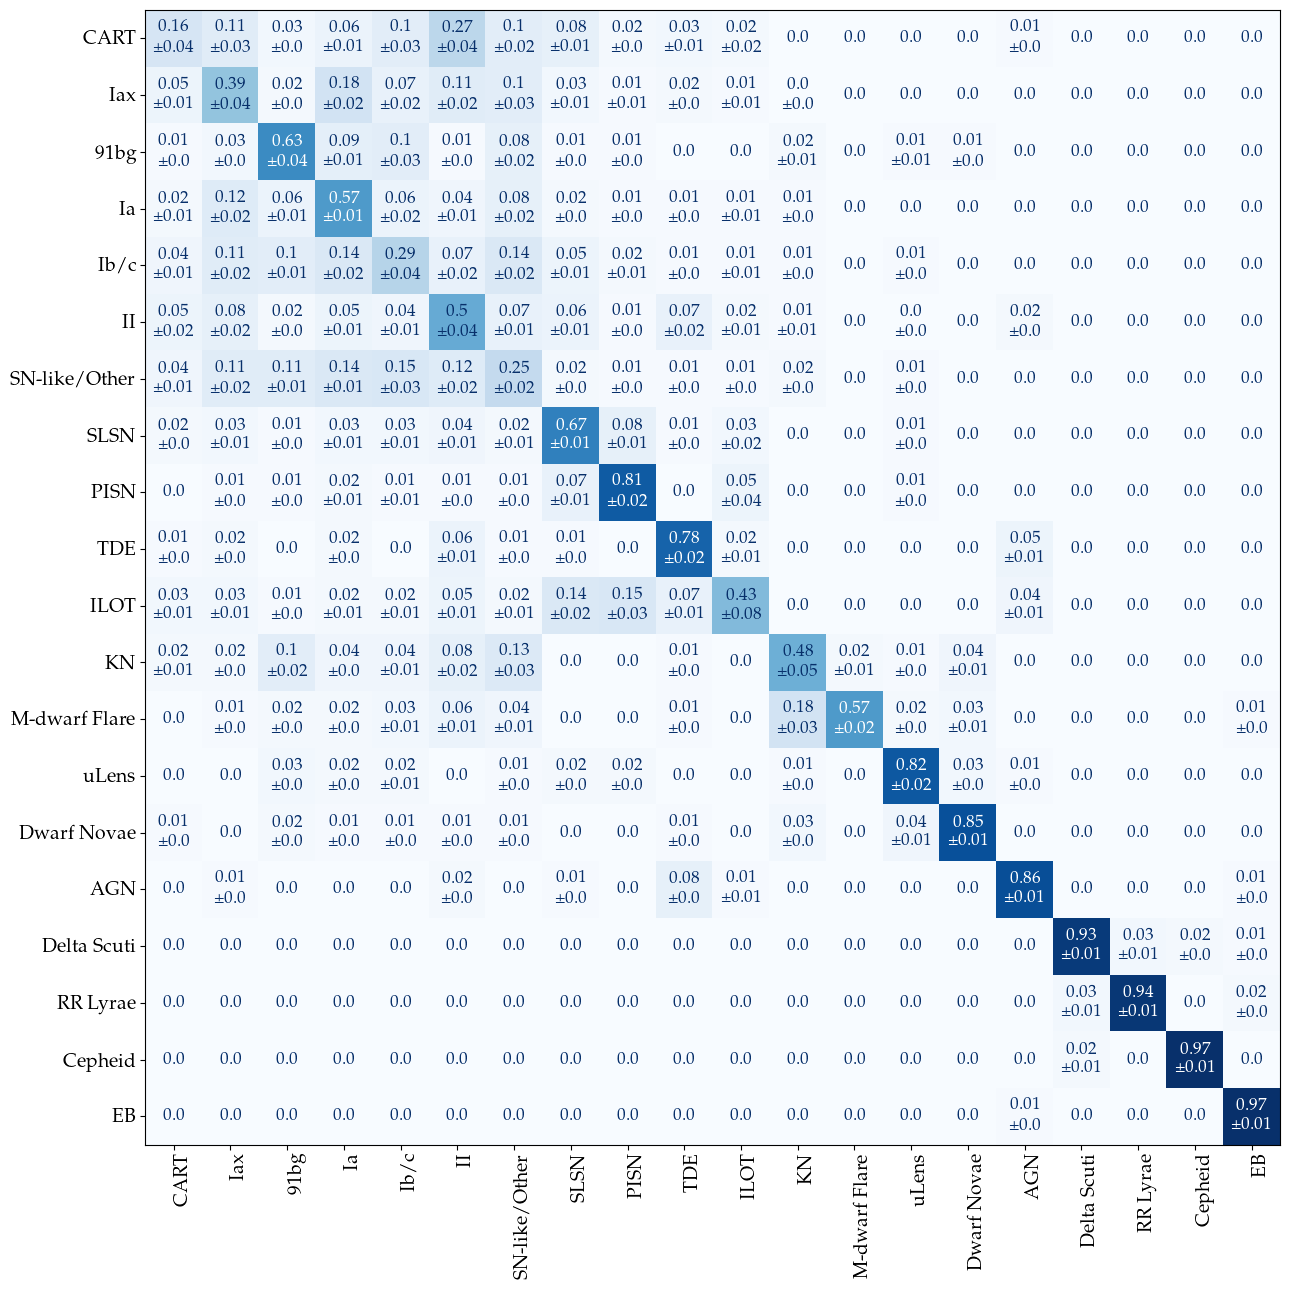

In [4]:
import json 
import torch

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report



with open('results/elasticc_1/ATAT_lc/dict_classes.json') as f:
   dict_classes = json.load(f)

print(dict_classes)
dict_classes = {v: k for k, v in dict_classes.items()}

path_exp = 'results/elasticc_1/ATAT_lc/Exp_cfg_-arch=lc'
folds = [0, 1, 2, 3, 4]

list_pred_folds = get_y_test_pred_folds(path_exp, dict_classes, folds)

# Suponiendo que tienes y_test_label1, y_pred_label1, y_test_label2, y_pred_label2, etc.
matrices = []
for y_test, y_pred in list_pred_folds:
    cm = confusion_matrix(y_test, y_pred, labels=order_classes, normalize='true')
    matrices.append(cm)

# Calculando la media y la desviación estándar
mean_matrix_lc = np.mean(matrices, axis=0)
std_matrix_lc = np.std(matrices, axis=0)

get_confusion_matrix(mean_matrix_lc, std_matrix_lc, order_classes)

## SwinV2

In [5]:
import mlflow
import logging

def get_experiment_id_mlflow(exp_name):
    experiment = mlflow.get_experiment_by_name(exp_name)
    if experiment:
        experiment_id = experiment.experiment_id
        logging.info(f"Experiment ID for '{exp_name}': {experiment_id}")
    else:
        logging.info(f"Experiment '{exp_name}' not found.")
    return experiment_id

def get_run_id_mlflow(experiment_id, run_name):
    filter_string = f"tags.mlflow.runName = '{run_name}'"
    runs = mlflow.search_runs(experiment_ids=[experiment_id], filter_string=filter_string)
    if not runs.empty:  # Check if the DataFrame is empty
        run_id = runs.iloc[0].run_id  # Get the run ID of the first row
        logging.info(f"Run ID for '{run_name}': {run_id}")
    else:
        logging.info(f"Run '{run_name}' not found in experiment '{experiment_id}'.")
    return run_id

def handle_ckpt_dir(config, fold=None):
    mlflow.set_tracking_uri(f"file:{config['checkpoint']['results_dir']}/ml-runs")
    exp_name = f"{config['checkpoint']['exp_name']}"
    exp_id = get_experiment_id_mlflow(exp_name)
    ckpt_dir = '{}/ml-runs/{}'.format(config['checkpoint']['results_dir'], exp_id)

    run_name = config['checkpoint']['run_name']
    if 'ft_classification' in exp_name:
        run_name = 'Fold_{}_{}'.format(fold, run_name)  
        run_id = get_run_id_mlflow(exp_id, run_name)
        ckpt_dir += '/{}'.format(run_id)
    else:
        run_id = get_run_id_mlflow(exp_id, run_name)
        ckpt_dir += '/{}'.format(run_id) 

    ckpt_dir += '/artifacts/model'
    return ckpt_dir

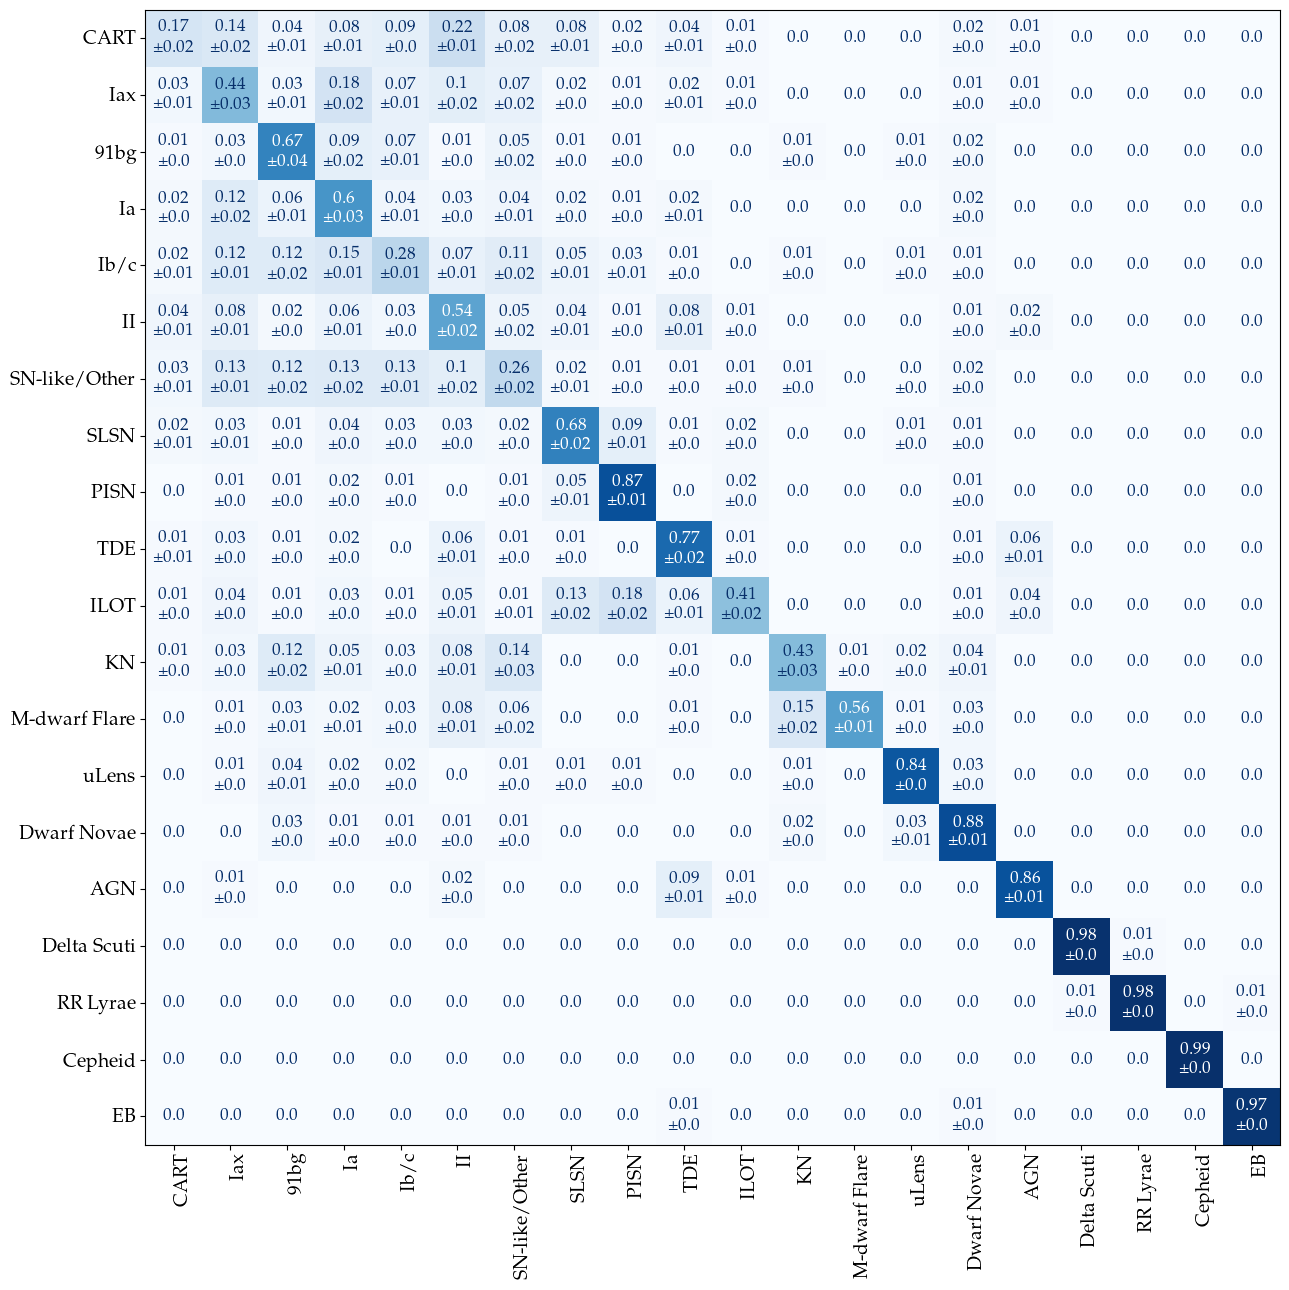

In [6]:
dict_fold_mlflow = {
    0: '2025-01-05_07-59-44',
    1: '2025-01-05_08-14-24',
    2: '2025-01-05_08-23-23',
    3: '2025-01-05_08-39-17',
    4: '2025-01-05_08-55-45',
}

matrices = []
for fold, run_name in dict_fold_mlflow.items(): 

    config = {
        'mlflow_dir': 'ml-runs',

        'checkpoint': {
            'exp_name': 'ft_classification/elasticc_1/best_params',
            'run_name': run_name,
            'results_dir': './results/elasticc_1',
        },

        'loader': {
            'fold': fold
            }
    }

    fold = config['loader']['fold']
    ckpt_dir = handle_ckpt_dir(config, fold=fold)
    ckpt_model = sorted(glob.glob(ckpt_dir + "/*.ckpt"))[-1]

    # Folder
    experiment_id = get_experiment_id_mlflow(config['checkpoint']['exp_name'])
    run_name = f"Fold_{fold}_{config['checkpoint']['run_name']}"
    run_id = get_run_id_mlflow(experiment_id, run_name)
    EXPDIR = '{}/ml-runs/{}/{}/artifacts'.format(config['checkpoint']['results_dir'], experiment_id, run_id)

    df_predictions = pd.read_parquet(f'{EXPDIR}/predictions_test.parquet')
    y_test = df_predictions['y_true'].values
    y_pred = df_predictions['y_pred'].values
    cm = confusion_matrix(y_test, y_pred, labels=order_classes, normalize='true')
    matrices.append(cm)

# Calculando la media y la desviación estándar
mean_matrix_swinv2 = np.mean(matrices, axis=0)
std_matrix_swinv2 = np.std(matrices, axis=0)

get_confusion_matrix(mean_matrix_swinv2, std_matrix_swinv2, order_classes)

## Joint plot of the confusion matrices

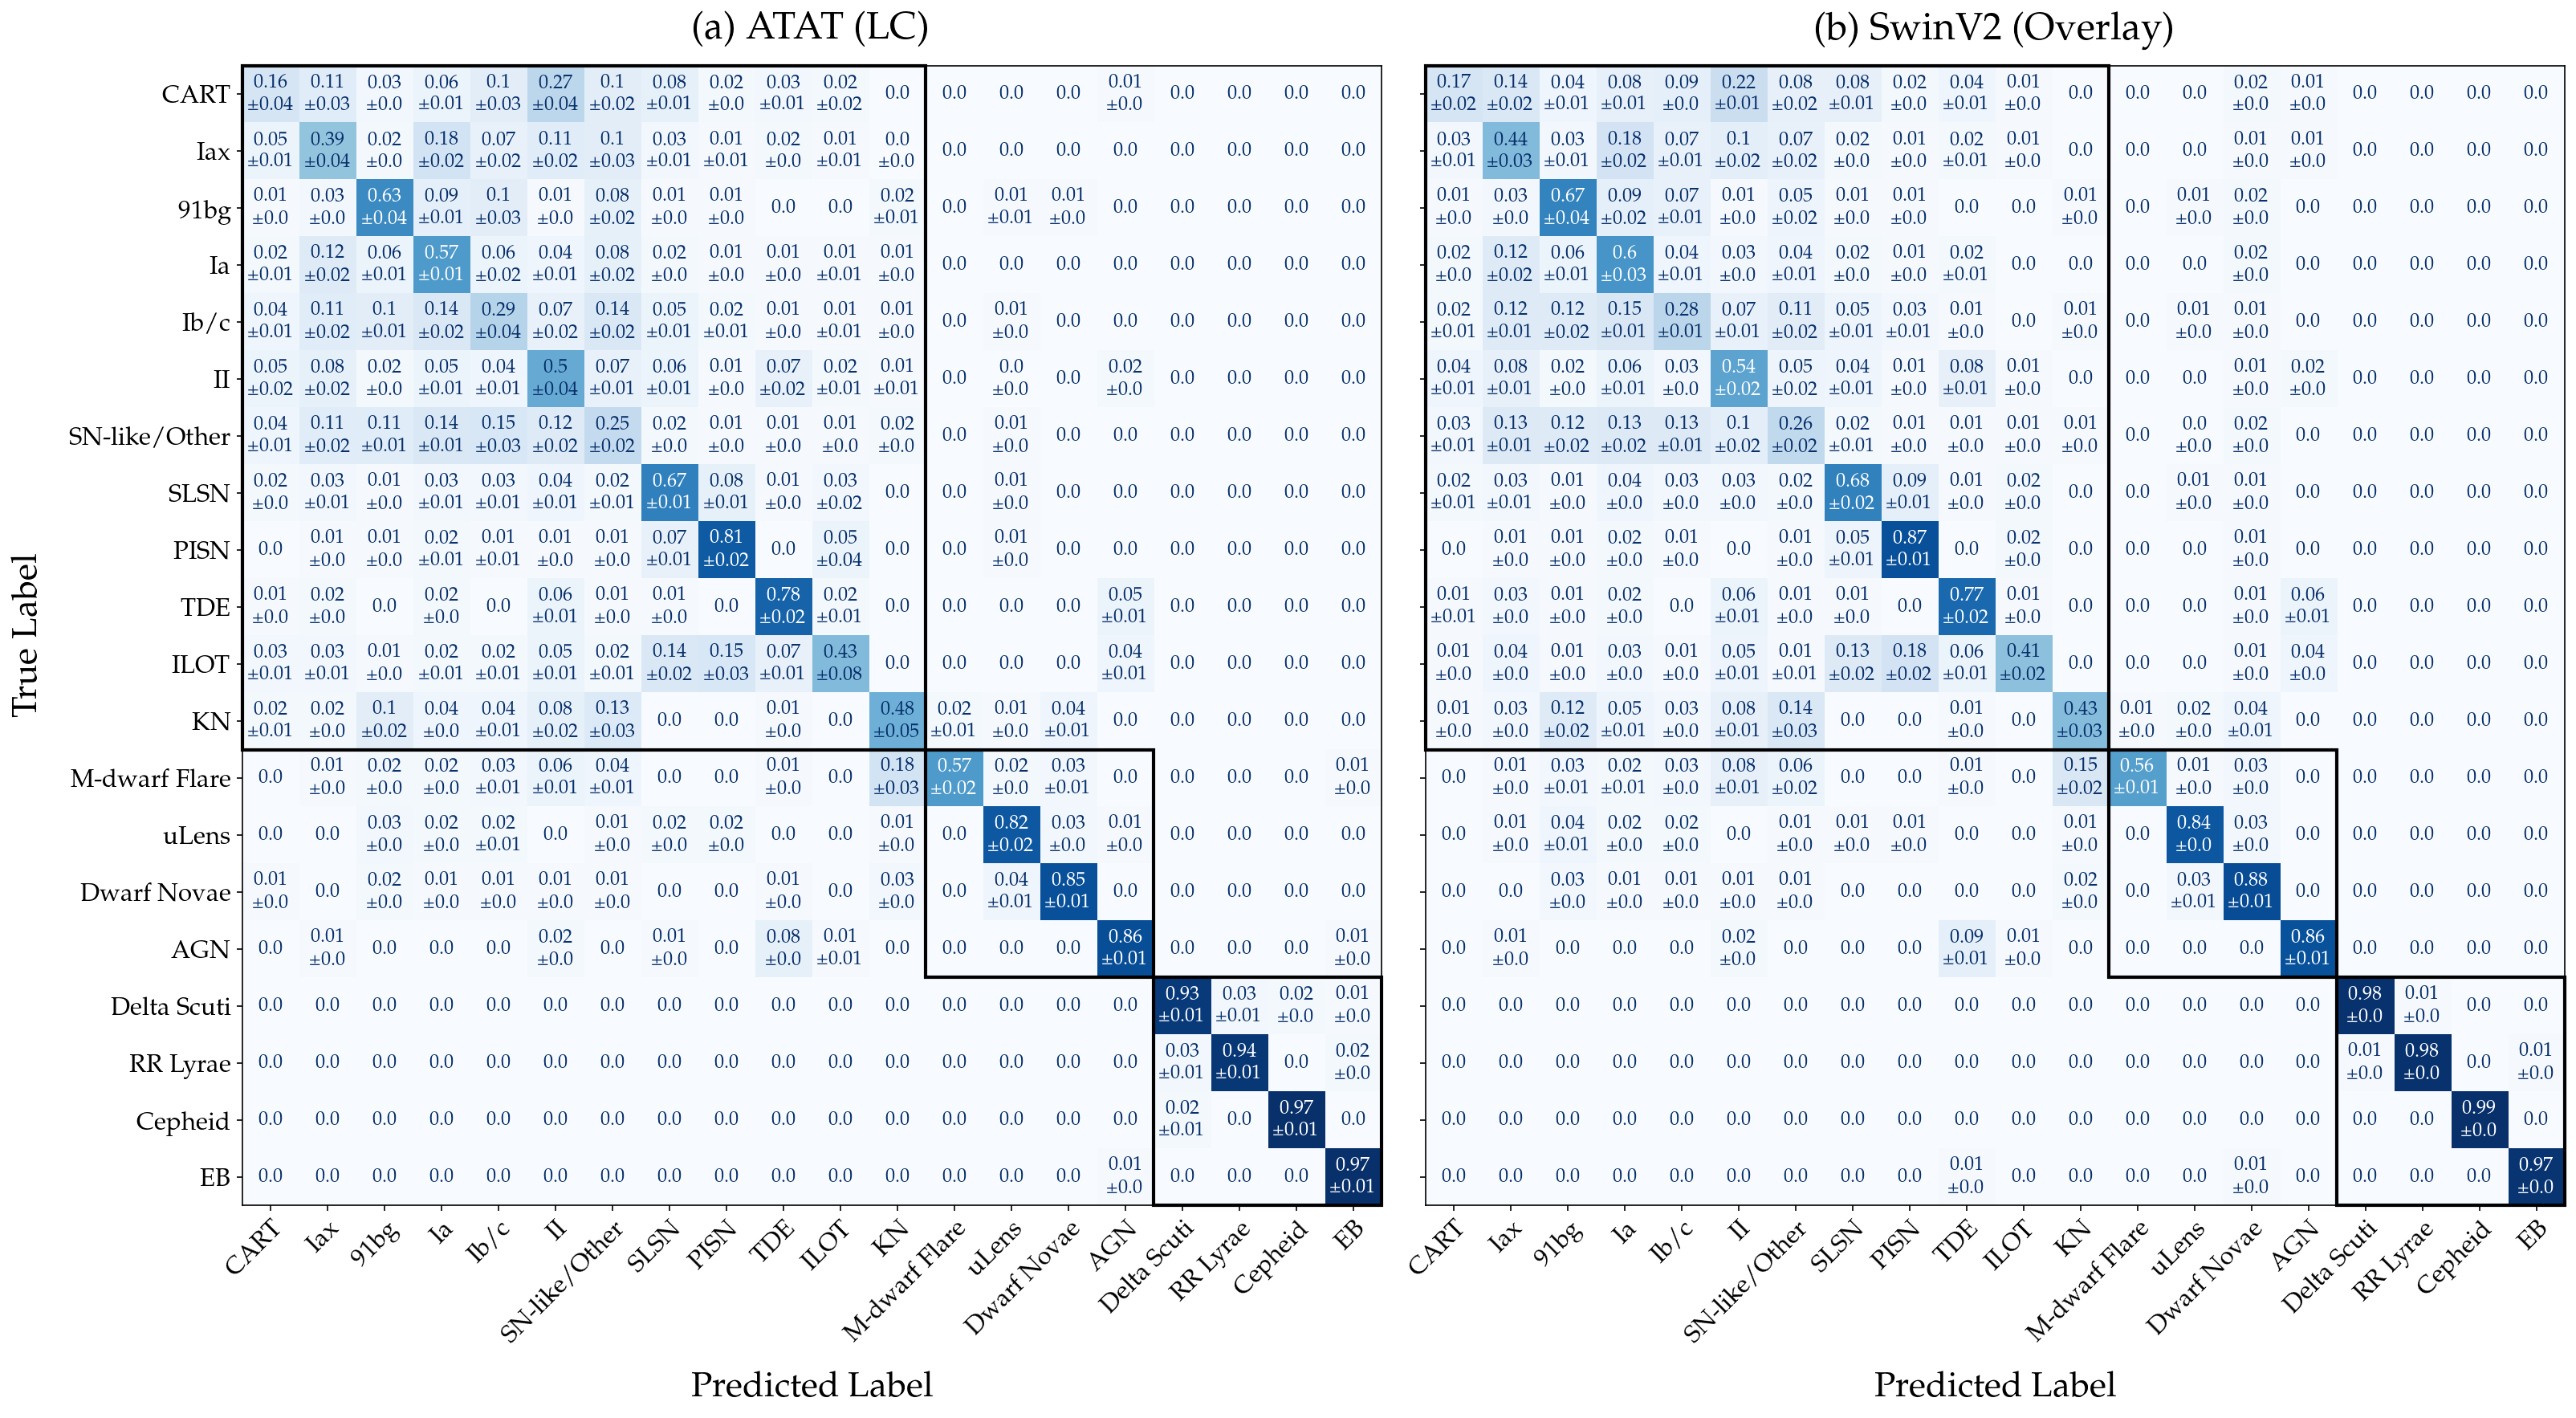

In [9]:
import matplotlib.patches as patches

# Graficando la matriz media
cmap = plt.cm.Blues  
#fig, ax = plt.subplots(figsize=(13, 13)) #, dpi=110)
fig, axes = plt.subplots(1, 2, figsize=(21.5, 21.5), sharey=True, dpi=150)

titles = ['(a) ATAT (LC)', '(b) SwinV2 (Overlay)']
mean_matrices_col = [mean_matrix_lc, mean_matrix_swinv2]
std_matrices_col = [std_matrix_lc, std_matrix_swinv2]

for cont, (ax, mean_matrix, std_matrix) in enumerate(zip(axes, mean_matrices_col, std_matrices_col)):
    im = ax.imshow(np.around(mean_matrix, decimals=2), interpolation='nearest', cmap=cmap)

    # color map
    new_color = cmap(1.0) 

    # Añadiendo manualmente las anotaciones con la media y desviación estándar
    for i in range(mean_matrix.shape[0]):
        for j in range(mean_matrix.shape[1]):
            if mean_matrix[i, j] >= 0.005:
                #print(mean_matrix[i, j])
                text = f'{np.around(mean_matrix[i, j], decimals=2)}\n±{np.around(std_matrix[i, j], decimals=2)}'
                color = "white" if mean_matrix[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
                ax.text(j, i, text, ha="center", va="center", color=color, fontsize=11.7)
            else:
                text = f'{np.around(mean_matrix[i, j], decimals=2)}'
                color = "white" if mean_matrix[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
                ax.text(j, i, text, ha="center", va="center", color=color, fontsize=11.7)

    # Ajustes finales y mostrar la gráfica
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_xticks(np.arange(len(order_classes)))
    ax.set_yticks(np.arange(len(order_classes)))
    ax.set_xticklabels(order_classes)
    ax.set_yticklabels(order_classes)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    #plt.setp(ax.get_xticklabels(), rotation=45, ha='center', va='top', rotation_mode="default")

    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    ax.xaxis.labelpad = 13
    ax.yaxis.labelpad = 13

    ax.set_title(titles[cont], fontsize=23, pad=16)
    ax.set_xlabel('Predicted Label', fontsize=21)

    if cont == 0:
        ax.set_ylabel('True Label', fontsize=21)

    for class_list in class_hierarchy.values():
        indices = [order_classes.index(label_name) for label_name in class_list if label_name in order_classes]
        if indices:
            min_idx, max_idx = min(indices), max(indices)
            rect = patches.Rectangle(
                (min_idx - 0.5, min_idx - 0.5),  # Esquina superior izquierda
                max_idx - min_idx + 1,  # Ancho
                max_idx - min_idx + 1,  # Alto
                linewidth=2, edgecolor="black", facecolor='none', clip_on=False
            )
            ax.add_patch(rect)

plt.tight_layout()
os.makedirs(path_save_results, exist_ok=True)
plt.savefig(f"{path_save_results}/cm_ATAT_SwinV2.pdf", format="pdf", bbox_inches="tight")
plt.show()